**consistency regularization**

MixMatch's augment
: random perturbation 추가하기 & ramp up 

1 supervised, unsupervised (FC layer)

2 decision boundary 구분하기

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons

In [33]:
X, y = make_moons(n_samples=5000, noise=0.1)

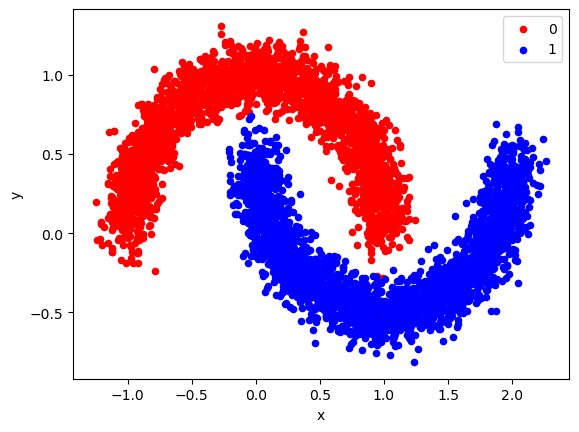

In [34]:
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:, 0], y=X[:, 1], label=y))
colors= {0: 'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [35]:
df

,x,y,label
0,0.789604,0.142043,0
1,-0.134461,0.265289,1
2,0.081260,0.898711,0
3,1.308642,-0.459861,1
4,1.568490,-0.342723,1
...,...,...,...
4995,0.559604,1.177316,0
4996,0.751777,0.487889,0
4997,0.299913,-0.148054,1
4998,0.521924,-0.273979,1


In [36]:
target = df.label
df.drop(['label'], axis=1, inplace=True)

X = df
y = target

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((4000, 2), (4000,), (1000, 2), (1000,))

In [38]:
# Train unsupervised / Train supervised split (unlabel : 80%)
# Train set / Validation set split
X_train, X_u_train, y_train, y_u_train = train_test_split(X_train, y_train, test_size=0.99, random_state=1,
                                                          shuffle=True, stratify=y_train)
X_train.shape, X_u_train.shape, y_train.shape, y_u_train.shape

((40, 2), (3960, 2), (40,), (3960,))

### Original

In [39]:
# dataset
import torch
import torch.utils.data as data

class BasicDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor):
        super(BasicDataset, self).__init__()

        self.x = x_tensor.to_numpy()
        self.y = y_tensor.to_numpy()
        
    def __getitem__(self, index):
        x = self.x[index:index+1]
        y = self.y[index:index+1]
        x = torch.FloatTensor(x)
        y = torch.FloatTensor(y)
        x = x.view(-1, )
        return x, y

    def __len__(self):
        return len(self.x)

class BasicDataset2(data.Dataset):
    def __init__(self, x_tensor):
        super(BasicDataset2, self).__init__()

        self.x = x_tensor.to_numpy()
        # self.y = y_tensor.to_numpy()
        
    def __getitem__(self, index):
        x = self.x[index:index+1]
        # y = self.y[index:index+1]
        x = torch.FloatTensor(x)
        # y = torch.FloatTensor(y)
        x = x.view(-1, )
        return x

    def __len__(self):
        return len(self.x)

In [40]:
# dataloader
from torch.utils.data import DataLoader

train_dataset = BasicDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(2, 100, bias=True)
        self.fc2 = nn.Linear(100, 100, bias=True)
        self.fc3 = nn.Linear(100, 1, bias=True)
        self.sig1 = nn.Sigmoid()
        self.drop = nn.Dropout(0.25)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = self.fc3(x)
        x = self.sig1(x)

        return x

In [42]:
model = Net()

In [43]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
model.to(device)

Net(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (sig1): Sigmoid()
  (drop): Dropout(p=0.25, inplace=False)
)

In [44]:
import torch.optim as optim

criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [45]:
train_dataset = BasicDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
unlabeled_dataset = BasicDataset2(X_u_train)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=99, shuffle=True)

In [46]:
print(train_dataloader.__len__())
print(unlabeled_dataloader.__len__())

40
40


test 1

In [47]:
for epoch in range(300):
    cost = 0.0
    model.train()

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss
    
    cost = cost / len(train_dataloader)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch : {epoch+1:4d},  Cost : {cost:.3f}")

Epoch :   10,  Cost : 0.220
Epoch :   20,  Cost : 0.243
Epoch :   30,  Cost : 0.257
Epoch :   40,  Cost : 0.229
Epoch :   50,  Cost : 0.244
Epoch :   60,  Cost : 0.226
Epoch :   70,  Cost : 0.228
Epoch :   80,  Cost : 0.237
Epoch :   90,  Cost : 0.218
Epoch :  100,  Cost : 0.208
Epoch :  110,  Cost : 0.235
Epoch :  120,  Cost : 0.225
Epoch :  130,  Cost : 0.205
Epoch :  140,  Cost : 0.229
Epoch :  150,  Cost : 0.224
Epoch :  160,  Cost : 0.191
Epoch :  170,  Cost : 0.210
Epoch :  180,  Cost : 0.194
Epoch :  190,  Cost : 0.209
Epoch :  200,  Cost : 0.235
Epoch :  210,  Cost : 0.220
Epoch :  220,  Cost : 0.222
Epoch :  230,  Cost : 0.216
Epoch :  240,  Cost : 0.251
Epoch :  250,  Cost : 0.239
Epoch :  260,  Cost : 0.218
Epoch :  270,  Cost : 0.223
Epoch :  280,  Cost : 0.230
Epoch :  290,  Cost : 0.221
Epoch :  300,  Cost : 0.215


In [48]:
test_dataset = BasicDataset(X_val, y_val)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def test(model, test_gen):
    model.eval()
    acc = []
    y = []
    pred = []
    for i, (x, y) in enumerate(test_gen):
        x = x.to(device)
        pred = model(x).to('cpu')
        pred = pred.detach().numpy()
        y = y.detach().numpy()
        for i in range(len(pred)):
            if pred[i] > 0.5:
                pred[i] = 1
            else:
                pred[i] = 0
        acc = accuracy_score(y, pred)
        if i % 5 == 0:
            print(i ,acc)
        y = y
        pred = pred
    print('Accuracy was : {}'.format(np.mean(acc)))
    print(confusion_matrix(y, pred))
    print(classification_report(y, pred))

In [49]:
test(model, test_dataloader)

Accuracy was : 1.0
[[4 0]
 [0 4]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



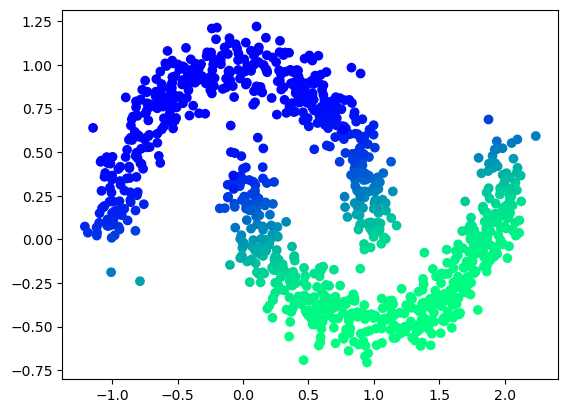

In [50]:
for i, (x, y) in enumerate(test_dataloader):
    x = x.to(device)
    pred = model(x)
    x = x.cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
    # for i in range(len(pred)):
    #     if pred[i] > 0.5:
    #         pred[i] = 1
    #     else:
    #         pred[i] = 0
    plt.scatter(x=x[:, 0], y=x[:, 1], c=pred, cmap=plt.cm.winter)

### MixMatch

In [51]:
def augment(points_x):
    noise = np.random.normal(0, 0.1)
    return points_x + noise

In [52]:
def sharpen(x, T):
    temp = x**(1/T)
    return temp / temp.sum(axis=1, keepdims=True)

In [53]:
def mixup(x1, x2, y1, y2, alpha):
    beta = np.random.beta(alpha, alpha)
    lam = max(beta, 1-beta) # 딱히 의미는 없지만 논문대로 구현하려고
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

In [54]:
class MixMatchLoss(torch.nn.Module):
    def __init__(self, lambda_u=0.8):
        super(MixMatchLoss, self).__init__()
        #self.lambda_u = lambda_u
        self.xent = torch.nn.BCELoss()
        self.mse = torch.nn.MSELoss()
    
    def forward(self, X, U, p, q, model, ramp):
        X_ = torch.cat([X, U], axis=0)
        preds = model(X_)
        # return self.xent(preds[:len(p)], p) + self.lambda_u * self.mse(preds[len(p):], q)
        return self.xent(preds[:len(p)], p) + ramp * self.mse(preds[len(p):], q)

In [55]:
def mixmatch(x, y, u, model, T=0.5, K=2, alpha=0.75):
    xb = augment(x)
    ub = [augment(u) for _ in range(K)]
    # qb = sharpen(sum(map(lambda i: model(i), ub)) / K, T) -> binary니까 sharpen X

    qb = sum(map(lambda i: model(i), ub)) / K

    Ux = torch.cat(ub, axis=0) # unlabel x
    Uy = torch.cat([qb for _ in range(K)], axis=0) # unlabel y (label 만든걸 k개씩 할당해주기)

    # indices = torch.randperm(len(xb)+len(Ux)) # label x + unlabel x 데이터 전체 개수

    # Wx = torch.cat([Ux, xb], axis=0)[indices] # unlabel + label x
    # Wy = torch.cat([qb, y], axis=0)[indices] # unlabel + label y를 각자 indices만큼 잘라 = 그냥 모델 전체 개수임
    
    # X, p = mixup(xb, Wx[:len(xb)], y, Wy[:len(xb)], alpha) # label과 W를 mixup
    # U, q = mixup(Ux, Wx[len(xb):], Uy, Wy[len(xb):], alpha) # unlabel과 W를 mixup => 제거하자

    X = xb
    U = Ux
    p = y
    q = Uy
    

    return X, U, p, q

### train

In [56]:
# augment 잘 되는지 테스트
for _ in range(1):
    xi, yi = next(iter(train_dataloader))

    xi = xi.to(device)
    yi = yi.to(device)
    
    print(xi)
    xa = augment(xi)
    print(xa)

tensor([[ 1.7825, -0.1785]], device='mps:0')
tensor([[ 1.7100, -0.2510]], device='mps:0')


In [57]:
model = Net()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [58]:
epochs = 300
per = epochs/5

for epoch in range(epochs):
    cost = 0.0
    model.train()

    # ramp up
    if epoch < per:
        ramp = 100
    elif epoch < per*2: 
        ramp = 200
    elif epoch < per*3: 
        ramp = 300
    elif epoch < per*4:
        ramp = 400
    else:
        ramp = 500

    #print(ramp)

    for _ in range(len(train_dataloader)):

        xi, yi = next(iter(train_dataloader))
        ui = next(iter(unlabeled_dataloader))
        
        # print(xi)

        xi = xi.to(device)
        yi = yi.to(device)
        ui = ui.to(device)
        
        X, U, p, q = mixmatch(xi, yi, ui, model, augment)

        criterion = MixMatchLoss()
        loss = criterion(X, U, p, q, model, ramp)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss
        
    cost = cost / len(train_dataloader)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch : {epoch+1:4d},  Cost : {cost:.3f}")

Epoch :   10,  Cost : 0.485
Epoch :   20,  Cost : 0.312
Epoch :   30,  Cost : 0.419
Epoch :   40,  Cost : 0.164
Epoch :   50,  Cost : 0.409
Epoch :   60,  Cost : 0.373
Epoch :   70,  Cost : 0.306
Epoch :   80,  Cost : 0.199
Epoch :   90,  Cost : 0.280
Epoch :  100,  Cost : 0.396
Epoch :  110,  Cost : 0.302
Epoch :  120,  Cost : 0.252
Epoch :  130,  Cost : 0.468
Epoch :  140,  Cost : 0.325
Epoch :  150,  Cost : 0.295
Epoch :  160,  Cost : 0.472
Epoch :  170,  Cost : 0.235
Epoch :  180,  Cost : 0.404
Epoch :  190,  Cost : 0.346
Epoch :  200,  Cost : 0.374
Epoch :  210,  Cost : 0.267
Epoch :  220,  Cost : 0.275
Epoch :  230,  Cost : 0.181
Epoch :  240,  Cost : 0.249
Epoch :  250,  Cost : 0.430
Epoch :  260,  Cost : 0.457
Epoch :  270,  Cost : 0.123
Epoch :  280,  Cost : 0.281
Epoch :  290,  Cost : 0.233
Epoch :  300,  Cost : 0.437


### test

In [59]:
test_dataset = BasicDataset(X_val, y_val)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [60]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def test(model, test_gen):
    model.eval()
    acc = []
    y = []
    pred = []
    for i, (x, y) in enumerate(test_gen):
        x = x.to(device)
        pred = model(x).to('cpu')
        pred = pred.detach().numpy()
        y = y.detach().numpy()
        for i in range(len(pred)):
            if pred[i] > 0.5:
                pred[i] = 1
            else:
                pred[i] = 0
        acc = accuracy_score(y, pred)
        if i % 5 == 0:
            print(i ,acc)
        y = y
        pred = pred
    print('Accuracy was : {}'.format(np.mean(acc)))
    print(confusion_matrix(y, pred))
    print(classification_report(y, pred))

In [61]:
test(model, test_dataloader)

Accuracy was : 0.875
[[3 0]
 [1 4]]
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         3
         1.0       1.00      0.80      0.89         5

    accuracy                           0.88         8
   macro avg       0.88      0.90      0.87         8
weighted avg       0.91      0.88      0.88         8



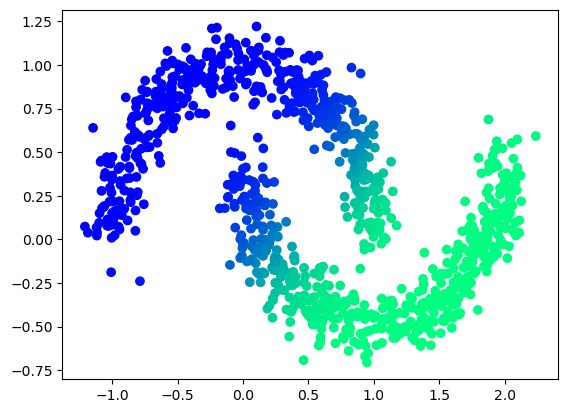

In [62]:
for i, (x, y) in enumerate(test_dataloader):
    x = x.to(device)
    pred = model(x)
    x = x.cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
    # for i in range(len(pred)):
    #     if pred[i] > 0.5:
    #         pred[i] = 1
    #     else:
    #         pred[i] = 0
    plt.scatter(x=x[:, 0], y=x[:, 1], c=pred, cmap=plt.cm.winter)